In [12]:
import numpy as np
import pandas as pd
import json
import os
import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torch.utils.data import Dataset, DataLoader
from transformers import BartForConditionalGeneration, BartTokenizer, AdamW
import matplotlib.pyplot as plt


Read in the Data

In [2]:
import os

# Get the directory you want to list files from
directory = '../../data/'

# List all files and directories in the specified directory
for filename in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, filename)):
        print(filename)


train_light.json
ambignq_light.zip
ambig_disambig_dev.csv
ambig_disambig_train.csv
LICENSE
dev_light.json


In [3]:
df_train = pd.read_csv('../../data/ambig_disambig_train.csv')
df_train.head()

,ambiguous_question,disambiguated_question
0,When did the simpsons first air on television?,When did the Simpsons first air on television ...
1,When did the simpsons first air on television?,When did the Simpsons first air as a half-hour...
2,What is the legal age of marriage in usa?,"What is the legal age of marriage, without par..."
3,What is the legal age of marriage in usa?,"What is the legal age of marriage, without par..."
4,What is the legal age of marriage in usa?,"What is the legal age of marriage, without par..."


In [4]:
df_dev = pd.read_csv('../../data/ambig_disambig_dev.csv')
df_dev.head()

,ambiguous_question,disambiguated_question
0,Why did the st louis cardinals move to arizona?,What ability caused the st louis cardinals mov...
1,Why did the st louis cardinals move to arizona?,What physical issue caused the st louis cardin...
2,Why did the st louis cardinals move to arizona?,What fan issue caused the st louis cardinals m...
3,Who is the current chairman of african union c...,Who is the 4th chairman of african union commi...
4,Who is the current chairman of african union c...,Who is the 3rd chairman of african union commi...


Model Set Up

In [5]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
# Load pre-trained model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')
# move the model to the GPU
model.to('cuda')

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=

In [6]:
inputs_train = list(df_train['ambiguous_question'])
targets_train = list(df_train['disambiguated_question'])

# Tokenize inputs and targets
inputs = tokenizer(inputs_train, padding=True, truncation=True, return_tensors='pt')
targets = tokenizer(targets_train, padding=True, truncation=True, return_tensors='pt')

Convert Dataset to PyTorch Format

In [7]:
class AmbigNQDataset(Dataset):
    def __init__(self, encodings, resultings):
        self.encodings = encodings
        self.resultings = resultings
        
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.resultings['input_ids'][idx]
        return item
    
    def __len__(self):
        return len(self.resultings['input_ids'])
    
dataset = AmbigNQDataset(inputs, targets)
loader = DataLoader(dataset, batch_size = 20, shuffle=True)

Fine-Tuning BART-Large

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
print(device)
# print(torch.cuda.is_available())

cuda


In [10]:
# load pre-trained BART-Large model for fine-tuning
epochs = 2
# model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')

optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

training_loss = []
# training loop
model.train() # put model in train mode
for epoch in range(epochs):
    for batch in loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        resultings = batch['labels'].to('cuda')
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=resultings)
        loss = outputs.loss
        training_loss.append(loss)
        loss.backward()
        optimizer.step()
        
        print(f"Epoch: {epoch}, Loss: {loss.item()}")
        
    


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 0, Loss: 14.636819839477539
Epoch: 0, Loss: 13.787623405456543
Epoch: 0, Loss: 12.738015174865723
Epoch: 0, Loss: 12.628256797790527
Epoch: 0, Loss: 12.067249298095703
Epoch: 0, Loss: 12.155261993408203
Epoch: 0, Loss: 11.52320671081543
Epoch: 0, Loss: 11.79874324798584
Epoch: 0, Loss: 11.3958101272583
Epoch: 0, Loss: 11.170926094055176
Epoch: 0, Loss: 11.003399848937988
Epoch: 0, Loss: 10.903605461120605
Epoch: 0, Loss: 11.11988639831543
Epoch: 0, Loss: 10.876297950744629
Epoch: 0, Loss: 10.781479835510254
Epoch: 0, Loss: 10.787046432495117
Epoch: 0, Loss: 10.504724502563477
Epoch: 0, Loss: 10.676658630371094
Epoch: 0, Loss: 10.505220413208008
Epoch: 0, Loss: 10.463607788085938
Epoch: 0, Loss: 10.16796875
Epoch: 0, Loss: 10.276021003723145
Epoch: 0, Loss: 9.992729187011719
Epoch: 0, Loss: 10.088196754455566
Epoch: 0, Loss: 9.938432693481445
Epoch: 0, Loss: 10.092947006225586
Epoch: 0, Loss: 9.866996765136719
Epoch: 0, Loss: 9.71047306060791
Epoch: 0, Loss: 9.609797477722168
Epo

Text(0, 0.5, 'Loss')

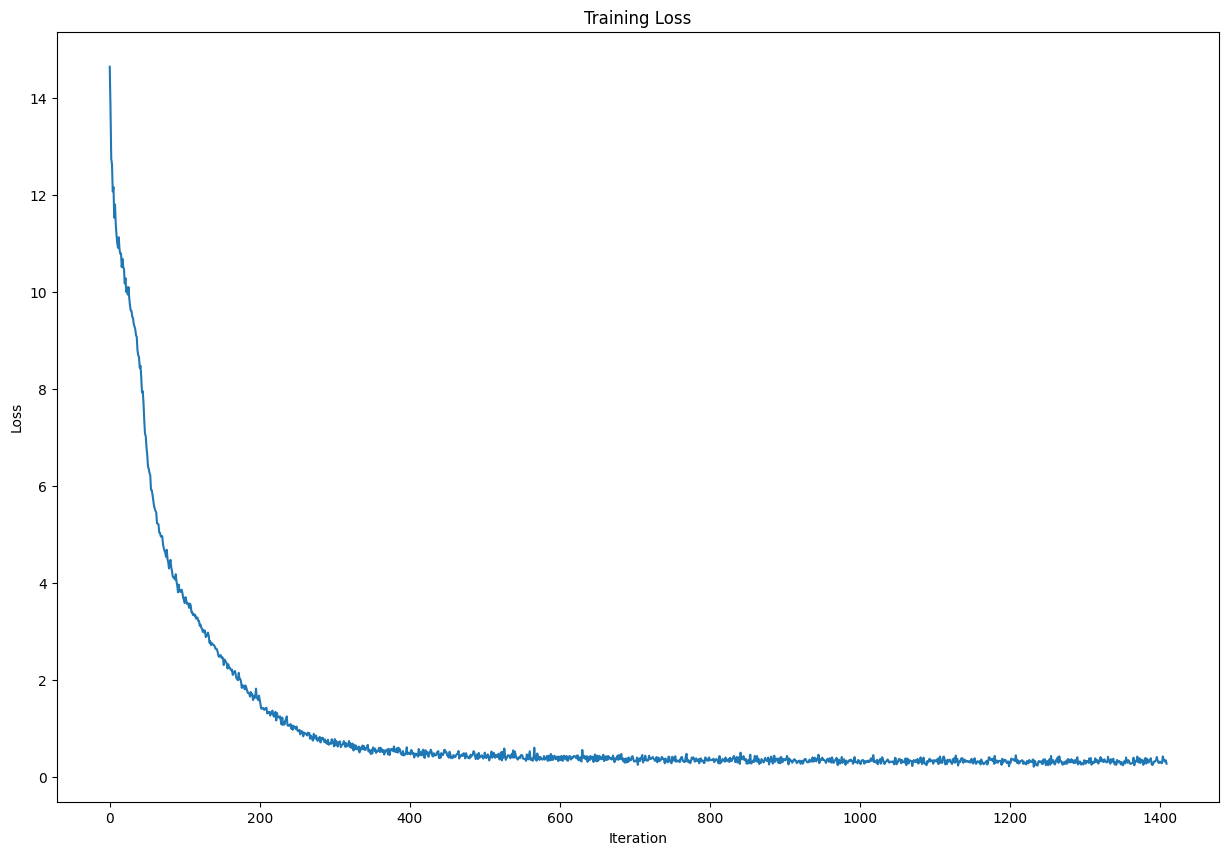

In [19]:
cpu_training_loss = [loss_item.item() for loss_item in training_loss]

plt.figure(figsize=(15, 10))
plt.title("Training Loss")
plt.plot(cpu_training_loss, label="Training")
plt.xlabel("Iteration")
plt.ylabel("Loss")

Save the Model

In [20]:
model.save_pretrained('pretrained_saves')
tokenizer.save_pretrained('pretrained_saves')

('pretrained_saves/tokenizer_config.json',
 'pretrained_saves/special_tokens_map.json',
 'pretrained_saves/vocab.json',
 'pretrained_saves/merges.txt',
 'pretrained_saves/added_tokens.json')

Only save model when dev_loss starts going up.